In [1]:
import imageio
import gymnasium as gym
import numpy as np
import gym_aloha
import mediapy as media
import torch
from act.policy import ACTPolicy

pygame 2.2.0 (SDL 2.30.2, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


/Users/Eugene/miniconda3/envs/lerobot/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/Eugene/miniconda3/envs/lerobot/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/Eugene/miniconda3/envs/lerobot/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <421678CD-1041-32CD-92EF-29D22242240C> /Users/Eugene/miniconda3/envs/lerobot/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
"""
This scripts demonstrates how to evaluate a pretrained policy from the HuggingFace Hub or from your local
training outputs directory. In the latter case, you might want to run examples/3_train_policy.py first.
"""

from pathlib import Path

import gym_aloha  # noqa: F401
import gymnasium as gym
import imageio
import numpy
import torch
from huggingface_hub import snapshot_download

from lerobot.common.policies.act.modeling_act import ACTPolicy

# Create a directory to store the video of the evaluation
output_directory = Path("lerobot/outputs/eval/act_aloha_sim_transfer_cube_human")
output_directory.mkdir(parents=True, exist_ok=True)

device = torch.device("mps")

# Download the diffusion policy for pusht environment
pretrained_policy_path = Path(snapshot_download("lerobot/act_aloha_sim_transfer_cube_human"))
# OR uncomment the following to evaluate a policy from the local outputs/train folder.
# pretrained_policy_path = Path("outputs/train/example_pusht_diffusion")

policy = ACTPolicy.from_pretrained(pretrained_policy_path)
policy.eval()
policy.to(device)

# Initialize evaluation environment to render two observation types:
# an image of the scene and state/position of the agent. The environment
# also automatically stops running after 300 interactions/steps.
# gym.envs.pprint_registry() to find out what's available
# ("AlohaInsertion-v0", "pixels"),
# ("AlohaInsertion-v0", "pixels_agent_pos"),
# ("AlohaTransferCube-v0", "pixels"),
# ("AlohaTransferCube-v0", "pixels_agent_pos"),
env = gym.make(
    "gym_aloha/AlohaTransferCube-v0",
    obs_type="pixels_agent_pos",
    max_episode_steps=300,
)


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

Loading weights from local directory


AttributeError: 'MjModel' object has no attribute 'bvh_geomid'

In [31]:

# Reset the policy and environmens to prepare for rollout
policy.reset()
numpy_observation, info = env.reset(seed=69)

# Prepare to collect every rewards and all the frames of the episode,
# from initial state to final state.
rewards = []
frames = []

# Render frame of the initial state
frames.append(env.render())


In [32]:
step = 0
done = False
# while len(frames) < 300:
while not done:
    # Prepare observation for the policy running in Pytorch
    state = torch.from_numpy(numpy_observation["agent_pos"])
    image = torch.from_numpy(numpy_observation["pixels"]["top"])

    # Convert to float32 with image from channel first in [0,255]
    # to channel last in [0,1]
    state = state.to(torch.float32)
    image = image.to(torch.float32) / 255
    image = image.permute(2, 0, 1)

    # Send data tensors from CPU to GPU
    state = state.to(device, non_blocking=True)
    image = image.to(device, non_blocking=True)

    # Add extra (empty) batch dimension, required to forward the policy
    state = state.unsqueeze(0)
    image = image.unsqueeze(0)

    # Create the policy input dictionary
    observation = {
        "observation.state": state,
        "observation.images.top": image,
    }

    # Predict the next action with respect to the current observation
    with torch.inference_mode():
        action = policy.select_action(observation)

    # Prepare the action for the environment
    numpy_action = action.squeeze(0).to("cpu").numpy()

    # Step through the environment and receive a new observation
    numpy_observation, reward, terminated, truncated, info = env.step(numpy_action)
    print(f"{step=} {reward=} {terminated=}")

    # Keep track of all the rewards and frames
    rewards.append(reward)
    frames.append(env.render())

    # The rollout is considered done when the success state is reach (i.e. terminated is True),
    # or the maximum number of iterations is reached (i.e. truncated is True)
    done = terminated | truncated | done
    step += 1

if terminated:
    print("Success!")
else:
    print("Failure!")

# Get the speed of environment (i.e. its number of frames per second).
fps = env.metadata["render_fps"]

media.show_video(frames, fps=fps)


step=0 reward=0 terminated=False
step=1 reward=0 terminated=False
step=2 reward=0 terminated=False
step=3 reward=0 terminated=False
step=4 reward=0 terminated=False
step=5 reward=0 terminated=False
step=6 reward=0 terminated=False
step=7 reward=0 terminated=False
step=8 reward=0 terminated=False
step=9 reward=0 terminated=False
step=10 reward=0 terminated=False
step=11 reward=0 terminated=False
step=12 reward=0 terminated=False
step=13 reward=0 terminated=False
step=14 reward=0 terminated=False
step=15 reward=0 terminated=False
step=16 reward=0 terminated=False
step=17 reward=0 terminated=False
step=18 reward=0 terminated=False
step=19 reward=0 terminated=False
step=20 reward=0 terminated=False
step=21 reward=0 terminated=False
step=22 reward=0 terminated=False
step=23 reward=0 terminated=False
step=24 reward=0 terminated=False
step=25 reward=0 terminated=False
step=26 reward=0 terminated=False
step=27 reward=0 terminated=False
step=28 reward=0 terminated=False
step=29 reward=0 termina

In [7]:
policy.keys()

odict_keys(['model.pos_table', 'model.transformer.encoder.layers.0.self_attn.in_proj_weight', 'model.transformer.encoder.layers.0.self_attn.in_proj_bias', 'model.transformer.encoder.layers.0.self_attn.out_proj.weight', 'model.transformer.encoder.layers.0.self_attn.out_proj.bias', 'model.transformer.encoder.layers.0.linear1.weight', 'model.transformer.encoder.layers.0.linear1.bias', 'model.transformer.encoder.layers.0.linear2.weight', 'model.transformer.encoder.layers.0.linear2.bias', 'model.transformer.encoder.layers.0.norm1.weight', 'model.transformer.encoder.layers.0.norm1.bias', 'model.transformer.encoder.layers.0.norm2.weight', 'model.transformer.encoder.layers.0.norm2.bias', 'model.transformer.encoder.layers.1.self_attn.in_proj_weight', 'model.transformer.encoder.layers.1.self_attn.in_proj_bias', 'model.transformer.encoder.layers.1.self_attn.out_proj.weight', 'model.transformer.encoder.layers.1.self_attn.out_proj.bias', 'model.transformer.encoder.layers.1.linear1.weight', 'model.t

In [10]:

env = gym.make("gym_aloha/AlohaInsertion-v0")
observation, info = env.reset()
frames = []

for _ in range(1000):
    action = policy.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    image = env.render()
    frames.append(image)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

media.show_video(frames, fps=25)

AttributeError: 'collections.OrderedDict' object has no attribute 'predict'

In [38]:
import mujoco
import numpy as np
import mediapy as media
from pathlib import Path
import pyquaternion
np.set_printoptions(precision=3, suppress=True, linewidth=100)


In [41]:
scene_path = "models/cube_pickup.xml"
model = mujoco.MjModel.from_xml_path(scene_path)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

""

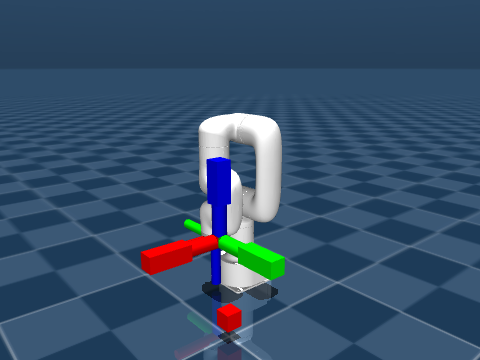

In [42]:
mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)

# Make a Renderer and a camera.
renderer = mujoco.Renderer(model, height=360, width=480)
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1.2
camera.elevation = -15
camera.azimuth = -130
camera.lookat = (0, 0, 0.3)

# Visualize site frames and labels
voption = mujoco.MjvOption()
voption.frame = mujoco.mjtFrame.mjFRAME_SITE
renderer.update_scene(data, camera, scene_option=voption)

media.show_image(renderer.render())


## Task
Pick up, put down

In [24]:
from gymnasium.envs.registration import register
import gym_lite6.env



In [25]:
from importlib import reload


register(id='UfactoryCubePickup-v0', entry_point='gym_lite6.env:UfactoryLite6Env')


/Users/Eugene/miniconda3/envs/lerobot/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment UfactoryCubePickup-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [71]:
reload(gym_lite6.env)
env = gym.make(
    "UfactoryCubePickup-v0",
    obs_type="pixels_pose",
    max_episode_steps=300,
)
observation, info = env.reset()

In [69]:
np.max(observation['pixels'])

255

""

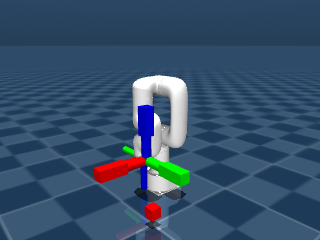

In [73]:
media.show_image(observation['pixels'])

In [74]:
# policy = ACTPolicy.from_pretrained(pretrained_policy_path)
# policy.eval()
# policy.to(device)

# Reset the policy and environmens to prepare for rollout
# policy.reset()
numpy_observation, info = env.reset(seed=69)

# Prepare to collect every rewards and all the frames of the episode,
# from initial state to final state.
rewards = []
frames = []

# Render frame of the initial state
frames.append(env.render())


step = 0
done = False
while len(frames) < 300:
# while not done:
    # Prepare observation for the policy running in Pytorch
    state = torch.from_numpy(np.hstack((numpy_observation["state"]["pose"], numpy_observation["state"]["gripper"])))
    image = torch.from_numpy(numpy_observation["pixels"])

    # Convert to float32 with image from channel first in [0,255]
    # to channel last in [0,1]
    state = state.to(torch.float32)
    image = image.to(torch.float32) / 255
    image = image.permute(2, 0, 1)

    # Send data tensors from CPU to GPU
    state = state.to(device, non_blocking=True)
    image = image.to(device, non_blocking=True)

    # Add extra (empty) batch dimension, required to forward the policy
    state = state.unsqueeze(0)
    image = image.unsqueeze(0)

    # Create the policy input dictionary
    observation = {
        "observation.state": state,
        "observation.images.top": image,
    }

    # Predict the next action with respect to the current observation
    with torch.inference_mode():
        # action = policy.select_action(observation)
        action = env.action_space.sample()

    action = np.hstack(action["pose"], action["gripper"])

    # Prepare the action for the environment
    numpy_action = action.squeeze(0).to("cpu").numpy()

    # Step through the environment and receive a new observation
    numpy_observation, reward, terminated, truncated, info = env.step(numpy_action)
    print(f"{step=} {reward=} {terminated=}")

    # Keep track of all the rewards and frames
    rewards.append(reward)
    frames.append(env.render())

    # The rollout is considered done when the success state is reach (i.e. terminated is True),
    # or the maximum number of iterations is reached (i.e. truncated is True)
    done = terminated | truncated | done
    step += 1

if terminated:
    print("Success!")
else:
    print("Failure!")

# Get the speed of environment (i.e. its number of frames per second).
fps = env.metadata["render_fps"]

media.show_video(frames, fps=fps)

AttributeError: 'collections.OrderedDict' object has no attribute 'squeeze'

In [75]:
action

OrderedDict([('gripper', 0),
             ('pos',
              array([ 0.697, -2.265,  0.292,  1.126,  0.332,  0.903,  0.12 ], dtype=float32))])